# Logistic Active Learning

In [2]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [3]:
import mclearn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline
plt.style.use('ggplot')

In [4]:
sdss = pd.read_hdf('data/sdss.h5', 'sdss')
target_col = 'class'
feature_cols = ['psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11', 'psfMag_i_sf11',
                'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11', 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11',
                'petroMag_u_sf11', 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

## Uncertainty Sampling and Query by Bagging

We start by training the logistic classifier with 20 random examples. Then each time we look at the entire training pool (which initally contains 60,000 examples) and assign each example a score. We query the example with the best score and then train the classifier again. This is repeated until we have 1000 examples in the training set. We do 10 trials of the experiment and take the average.

Two uncertainty sampling heuristics are tested:

* Picking the candidate that displays the greatest Shannon entropy:

\begin{align}
-\sum_c q_c \log(q_c)
\end{align}

* Picking the candidate with the smallest margin:

\begin{align}
M_n = \left| p(c \mid \mathbf{x}_n) - p(c' \mid \mathbf{x}_n) \right|
\end{align}

And two query by bagging heuristics are tested:

* Picking the candidate with the smallest average margin.

* Picking the candidate with the largest value of the average Kullback-Leibler divergence from the average:
\begin{align}
	\dfrac{1}{B} \sum_{b=1}^B \text{KL}(f_b \mid\mid f_\text{avg})
\end{align}

Note that the KL divergence of $Q$ from $P$ is defined as

\begin{align}
	D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \ln\frac{P(i)}{Q(i)}.
\end{align}

This KL divergence measures the amount of information lost when $Q$ is used to approximate $P$. In the active learning context, $Q$ is the average prediction probability of the committee, while $P$ is the prediction of a particular committee member.

In [5]:
# initialise the main classifier
logistic_classifier = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')

# list of all heuristics to be used (and the paths where results are saved)
heuristics = [mclearn.random_h, mclearn.entropy_h, mclearn.margin_h, mclearn.qbb_margin_h, mclearn.qbb_kl_h]
curve_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

# set up the logistic committee
committee = []
committee_size = 8
for i in range(committee_size):
    member = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
    committee.append(member)

### Original Training Pool

In [1]:
pickle_paths_default = ['pickle/05_logistic_active_learning/default_random.pickle',
                        'pickle/05_logistic_active_learning/default_entropy.pickle',
                        'pickle/05_logistic_active_learning/default_margin.pickle',
                        'pickle/05_logistic_active_learning/default_qbb_margin.pickle',
                        'pickle/05_logistic_active_learning/default_qbb_kl.pickle']

In [ ]:
mclearn.active_learning_experiment(
    sdss, feature_cols, target_col, logistic_classifier, heuristics, committee, pickle_paths_default)

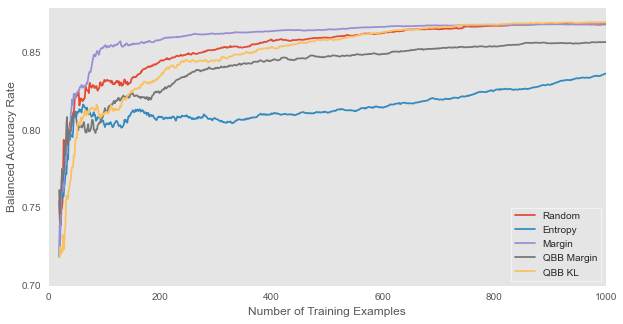

In [6]:
learning_curves = []
for pickle_path in pickle_paths_default:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))
        
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig('plots/lc_active_logistic_default.pdf', bbox_inches='tight')

### Balanced Training Pool

In [7]:
pickle_paths_balanced = ['pickle/05_logistic_active_learning/balanced_random.pickle',
                        'pickle/05_logistic_active_learning/balanced_entropy.pickle',
                        'pickle/05_logistic_active_learning/balanced_margin.pickle',
                        'pickle/05_logistic_active_learning/balanced_qbb_margin.pickle',
                        'pickle/05_logistic_active_learning/balanced_qbb_kl.pickle']

In [ ]:
mclearn.active_learning_experiment(sdss, feature_cols, target_col, logistic_classifier,
    heuristics, committee, pickle_paths_balanced, balanced_pool=True)

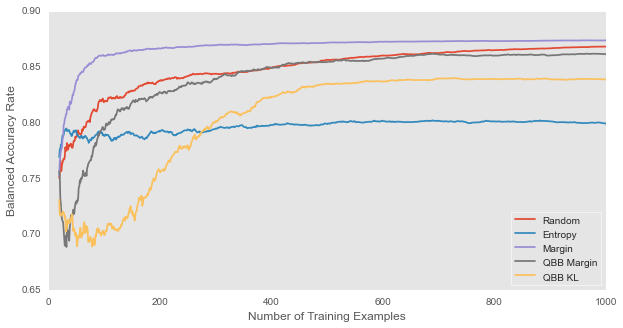

In [8]:
learning_curves = []
for pickle_path in pickle_paths_balanced:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))
        
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig('plots/lc_active_logistic_balanced.pdf', bbox_inches='tight')

### Polynomial 2 Transformation and Multinomial Regression

Let's see what happens if we use the true multinomial logistic regression (instead of one-vs-rest) and a polynomial transformation of the features. Due to the increase in the number of features after the transformation, we have reduce the number of trials down to 3 (instead of 10) for each curve.

In [10]:
# initialise the main classifier
logistic_classifier = LogisticRegression(multi_class='multinomial', penalty='l1', C=0.01, random_state=2,
                                         class_weight='auto', solver='lbfgs')

# list of all heuristics to be used (and the paths where results are saved)
heuristics = [mclearn.random_h, mclearn.entropy_h, mclearn.margin_h, mclearn.qbb_margin_h, mclearn.qbb_kl_h]
curve_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

# set up the logistic committee
committee = []
committee_size = 3
for i in range(committee_size):
    member = LogisticRegression(multi_class='multinomial', penalty='l1', C=0.01, random_state=2,
                                class_weight='auto', solver='lbfgs')
    committee.append(member)
    
pickle_paths_multinomial_2 = ['pickle/05_logistic_active_learning/multinomial_2_random.pickle',
                              'pickle/05_logistic_active_learning/multinomial_2_entropy.pickle',
                              'pickle/05_logistic_active_learning/multinomial_2_margin.pickle',
                              'pickle/05_logistic_active_learning/multinomial_2_qbb_margin.pickle',
                              'pickle/05_logistic_active_learning/multinomial_2_qbb_kl.pickle']

In [ ]:
mclearn.active_learning_experiment(sdss, feature_cols, target_col, logistic_classifier, heuristics,
                                   committee, pickle_paths_default, degree=2, n_trials=3)

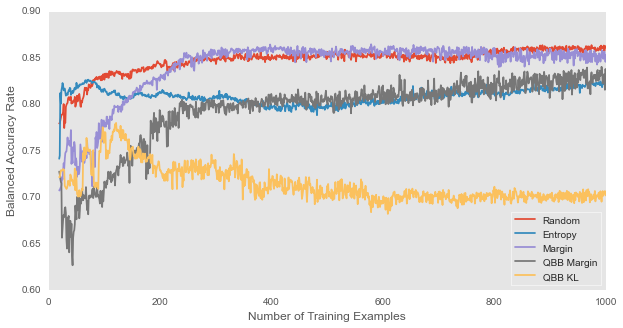

In [11]:
learning_curves = []
for pickle_path in pickle_paths_multinomial_2:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))
        
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig('plots/lc_active_logistic_multinomial_2.pdf', bbox_inches='tight')

It looks like we have more volatility here. Now this could be because this is only the average of 3 trials. However below we replot the first set of learning curves (OVR, no transformation, unmodified training pool) by taking the average of only the first three trials. With this, it still seems that the true multinomial approach produces much less stable probabilities.

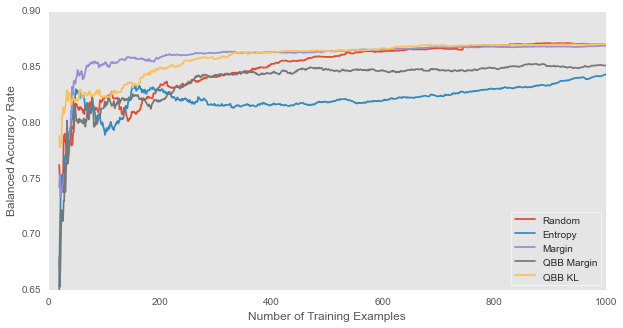

In [29]:
learning_curves = []
for pickle_path in pickle_paths_default:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))

for i, curve in enumerate(learning_curves):
    learning_curves[i] = curve[:3]
    
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig('plots/lc_active_logistic_default_first_3.pdf', bbox_inches='tight')

## Variance and Entropy Estimation

Finally we test two further heuristics. The first one involves picking the candidate that will mininise the variance of the predictions. Using Taylor series approximation, the variance is estimated as $tr(AF^{-1})$ in logistic regression, where $F$ is the Fisher information matrix and $A$ is defined as:

\begin{align}
A &= \sum_n \sum_c \mathbf{g}_n(c) ~ \mathbf{g}_n(c)^T
\end{align}

where $\mathbf{g}_n(c)$ is the gradient vector. Our implementation involves a vetorised computation of $A$ and $F$.

For the second heuristic, we pick the example that will minimise the expected entropy of the alogrithm's prediction. The entropy can be computed as follows:

\begin{align}
CC &= - \sum_{p \in \text{Pool}} \sum_c p(c \mid \mathbf{x}_p) \log p(c \mid \mathbf{x}_p)
\end{align}

In [5]:
heuristics = [mclearn.pool_variance_h, mclearn.pool_entropy_h]
curve_labels = ['Pool Variance', 'Pool Entropy']
pickle_paths_pool = ['pickle/05_logistic_active_learning/pool_variance.pickle',
                     'pickle/05_logistic_active_learning/pool_entropy.pickle']

In [ ]:
mclearn.active_learning_experiment(sdss, feature_cols, target_col, logistic_classifier, heuristics, None,
                                   pickle_paths_pool, C=1, random_n=300, pool_sample_size=300)